___
<a href='https://honglab.ai'><p style="text-align:center;"><img src='https://lh3.googleusercontent.com/lY3ySXooSmwsq5r-mRi7uiypbo0Vez6pmNoQxMFhl9fmZJkRHu5lO2vo7se_0YOzgmDyJif9fi4_z0o3ZFdwd8NVSWG6Ea80uWaf3pOHpR4GHGDV7kaFeuHR3yAjIJjDgfXMxsvw=w2400'  class="center" width="50%" height="50%"/></p></a>
___
<center><em>Content Copyright by HongLab, Inc.</em></center>

## 대형언어모델(LLM) 바닥부터 만들기

[유튜브 강의 영상 링크](https://youtu.be/osv2csoHVAo)

[홍정모 연구소 디스코드 링크](https://discord.com/invite/kgR9xJkbsV)

[홍정모 연구소 홈페이지 링크](https://www.honglab.ai/)

#### 참고 자료
- [Andrej Karpathy 유튜브](https://www.youtube.com/andrejkarpathy)
- [Build a Large Language Model (From Scratch)](https://www.manning.com/books/build-a-large-language-model-from-scratch)
- [Om-Alve/smolGPT 깃헙](https://github.com/Om-Alve/smolGPT)
- 트랜스포머 논문 - [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
- OpenAI GPT2 논문 - [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)



#### 안내사항

LLM의 핵심 개념을 개인 PC에서도 간단하게 실습하면서 공부할 수 있는 학습 자료입니다. 널리 알려진 교육/학술 자료들을 참고하여 쉽게 공부할 수 있도록 요약하고 정리한 것입니다. 코딩 스타일이나 활용 범위에 대해 오해 없으시길 바랍니다.

윈도우11/WSL, Python 3.9.20, Pytorch 2.6, CUDA 12.6 에서 작동을 확인하였습니다.

#### 전체 과정 요약

LLM 기반 AI 에이전트를 만들때는 핵심이 되는 LLM이 필요한데요, LLM을 바닥부터 만드는 경우 보다는 공개되어 있는 LLM 모델들을 가져다가 나의 용도에 맞도록 다듬어서 사용하는 것이 일반적입니다. 다만, 최근에는 LLM을 바닥부터 만드는 기술에 대한 진입장벽이 낮아지고 있어서 회사별로 필요한 LLM을 바닥부터 각자 만들어 사용하게 될 가능성도 높아지고 있습니다.

LLM을 만들 때는

1. 사전훈련(pretraining)으로 일반적인 언어 능력을 가르친 후에
2. 미세조정(fine tuning) 단계에서 특정 업무에 적응

시키는 것이 기본이 됩니다. 여기에

3. 데이터베이스(+인터넷) 검색 기능을 추가

하면 지식의 범위와 정확성을 높일 수 있습니다. 사람이 생각을 거듭하여 더 깊이있는 결론을 이끌어 내듯이 LLM도

4. 내부적으로 질의를 반복하여 더 좋은 결론을 도출

하도록 만들 수 있습니다.

여기서는 LLM의 기본 원리를 이해하기 위해서 사전훈련 과정을 바닥부터 진행해보겠습니다. 훈련 과정의 큰 틀은 일반적인 머신러닝 절차를 따릅니다.

1. 훈련 데이터 준비
1. 데이터 로더 정의
1. 모델 정의
1. 훈련
1. 결과 확인

#### 훈련 데이터 준비

준비한 텍스트 파일을 읽어 들여서 정리한 후에 앞에 cleaned_가 붙은 파일 이름으로 정리합니다.
> 예시) alice.txt &rarr; cleaned_alice.txt

- 캐글 해리포터 책 - [Harry Potter Books](https://www.kaggle.com/datasets/shubhammaindola/harry-potter-books?select=02+Harry+Potter+and+the+Chamber+of+Secrets.txt)
- 캐글 앨리스 책 - [alice.txt](https://www.kaggle.com/datasets/leelatte/alicetxt)
- 훈련 데이터나 가중치는 제가 배포하지 않습니다. 직접 다운받거나 준비하셔야합니다.

In [1]:
!pwd
!pip install kaggle
!pip install tiktoken

/content


In [ ]:
import os
from dotenv import load_dotenv

load_dotenv()

# 환경 변수 사용
kaggle_username = os.getenv("KAGGLE_USERNAME")
kaggle_key = os.getenv("KAGGLE_KEY")

print(f"KAGGLE_USERNAME: {kaggle_username}")
print(f"KAGGLE_KEY: {kaggle_key}")

!kaggle datasets download shubhammaindola/harry-potter-books
!mkdir harry_data
!unzip /content/harry-potter-books.zip -d harry_data

KAGGLE_USERNAME: habogu
KAGGLE_KEY: 986f61db73e18e04f1c3cac004c1d0c6
Dataset URL: https://www.kaggle.com/datasets/shubhammaindola/harry-potter-books
License(s): CC0-1.0
harry-potter-books.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: harry_data: File exists
unzip:  cannot find or open /content/harry-potter-books.zip, /content/harry-potter-books.zip.zip or /content/harry-potter-books.zip.ZIP.


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import os
import re

def clean_text(filename):
    root_path = "harry_data/"
    file_path = os.path.join(root_path, filename) # 원래 파일 경로 생성

    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            book_text = file.read()

        cleaned_text = re.sub(r'\n+', ' ', book_text)  # 줄바꿈을 빈칸으로 변경
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text)  # 여러 빈칸을 하나의 빈칸으로

        print(f"cleaned_{filename}", len(cleaned_text), "characters")  # 글자 수 출력

        cleaned_file_path = os.path.join(root_path, f"cleaned_{filename}") # 정리된 파일 경로 생성
        with open(cleaned_file_path, 'w', encoding='utf-8') as cleaned_file:
            cleaned_file.write(cleaned_text) # 정리된 텍스트를 파일에 저장

    except FileNotFoundError:
        print(f"파일을 찾을 수 없습니다: {file_path}")
    except Exception as e:
        print(f"오류 발생: {e}")

filenames_list = ["02 Harry Potter and the Chamber of Secrets.txt"]

for filename in filenames_list:
    clean_text(filename) # filename을 인자로 전달

cleaned_02 Harry Potter and the Chamber of Secrets.txt 488771 characters


#### 토큰화

UTF-8 BPE(Bype Pair Encoding)

In [4]:
import tiktoken # pip install tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

text = "Harry Potter was a wizard."

tokens = tokenizer.encode(text)

print("글자수:", len(text), "토큰수", len(tokens))
print(tokens)
print(tokenizer.decode(tokens))
for t in tokens:
    print(f"{t}\t -> {tokenizer.decode([t])}")

글자수: 26 토큰수 6
[18308, 14179, 373, 257, 18731, 13]
Harry Potter was a wizard.
18308	 -> Harry
14179	 ->  Potter
373	 ->  was
257	 ->  a
18731	 ->  wizard
13	 -> .


In [9]:
!ls -al
!pwd

total 2356
drwxr-xr-x 1 root root    4096 Feb 24 11:57 .
drwxr-xr-x 1 root root    4096 Feb 24 11:50 ..
drwxr-xr-x 4 root root    4096 Feb 20 14:24 .config
drwxr-xr-x 2 root root    4096 Feb 24 12:00 harry_data
-rw-r--r-- 1 root root 2390829 May  3  2024 harry-potter-books.zip
drwxr-xr-x 1 root root    4096 Feb 20 14:24 sample_data
/content


In [ ]:
# from transformers import AutoTokenizer # pip install transformers

# tokenizer = AutoTokenizer.from_pretrained("LGAI-EXAONE/EXAONE-3.5-7.8B-Instruct")  # KoGPT2 사용
# # tokenizer = AutoTokenizer.from_pretrained("skt/kogpt2-base-v2")  # KoGPT2 사용

# print("Vocab size :", len(tokenizer))

# text = "대사께서는 도(道)를 얻은 모양이구려."

# tokens = tokenizer.encode(text)

# print(len(text), len(tokens))
# print(tokens)
# print(tokenizer.decode(tokens))

In [10]:
for char in text:
    token_ids = tokenizer.encode(char)     # 한 글자씩 인코딩(토큰화)
    decoded = tokenizer.decode(token_ids)  # 한 글자씩 디코딩
    print(f"{char} -> {token_ids} -> {decoded}")

H -> [39] -> H
a -> [64] -> a
r -> [81] -> r
r -> [81] -> r
y -> [88] -> y
  -> [220] ->  
P -> [47] -> P
o -> [78] -> o
t -> [83] -> t
t -> [83] -> t
e -> [68] -> e
r -> [81] -> r
  -> [220] ->  
w -> [86] -> w
a -> [64] -> a
s -> [82] -> s
  -> [220] ->  
a -> [64] -> a
  -> [220] ->  
w -> [86] -> w
i -> [72] -> i
z -> [89] -> z
a -> [64] -> a
r -> [81] -> r
d -> [67] -> d
. -> [13] -> .


#### 데이터로더(DataLoader)

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, txt, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # token_ids = tokenizer.encode("<|endoftext|>" + txt, allowed_special={"<|endoftext|>"})
        token_ids = tokenizer.encode(txt)

        print("# of tokens in txt:", len(token_ids))

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

# with open("cleaned_묵향 1-36권 [전동조].txt", 'r', encoding='utf-8-sig') as file: # 선택: -sig를 붙여서 BOM 제거
with open("harry_data/cleaned_02 Harry Potter and the Chamber of Secrets.txt", 'r', encoding='utf-8-sig') as file: # 선택: -sig를 붙여서 BOM 제거
    txt = file.read()

dataset = MyDataset(txt, max_length = 32, stride = 4)

train_loader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

# 주의: test, valid는 생략하였습니다.

# of tokens in txt: 130520


In [14]:
dataiter = iter(train_loader)

x, y = next(dataiter)

print(tokenizer.decode(x[0].tolist()))
print(tokenizer.decode(y[0].tolist()))


 my next class —” And he hurried off. “Prepare his class,” Ron sneered after him. “Gone to curl
 next class —” And he hurried off. “Prepare his class,” Ron sneered after him. “Gone to curl his


#### 뉴럴네트워크 모델 정의

모델 정의는 교재 "[Build a Large Language Model (From Scratch)](https://www.manning.com/books/build-a-large-language-model-from-scratch)"에서 제공하는 [예제 코드](https://github.com/rasbt/LLMs-from-scratch)를 약간 수정하였습니다.


In [15]:
# 모델을 정의할 때 사용하는 상수들

VOCAB_SIZE = tokenizer.n_vocab # 50257 Tiktoken
#VOCAB_SIZE = len(tokenizer) # AutoTokenizer
CONTEXT_LENGTH = 128  # Shortened context length (orig: 1024)
EMB_DIM = 768  # Embedding dimension
NUM_HEADS = 12  # Number of attention heads
NUM_LAYERS = 12  # Number of layers
DROP_RATE = 0.1  # Dropout rate
QKV_BIAS = False  # Query-key-value bias

In [16]:
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()

        assert d_out % NUM_HEADS == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.head_dim = d_out // NUM_HEADS

        self.W_query = nn.Linear(d_in, d_out, bias=QKV_BIAS)
        self.W_key = nn.Linear(d_in, d_out, bias=QKV_BIAS)
        self.W_value = nn.Linear(d_in, d_out, bias=QKV_BIAS)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(DROP_RATE)
        self.register_buffer('mask', torch.triu(torch.ones(CONTEXT_LENGTH, CONTEXT_LENGTH), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, NUM_HEADS, self.head_dim)
        values = values.view(b, num_tokens, NUM_HEADS, self.head_dim)
        queries = queries.view(b, num_tokens, NUM_HEADS, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)

        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(EMB_DIM, 4 * EMB_DIM),
            GELU(),
            nn.Linear(4 * EMB_DIM, EMB_DIM),
        )

    def forward(self, x):
        return self.layers(x)

class TransformerBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=EMB_DIM,
            d_out=EMB_DIM)

        self.ff = FeedForward()
        self.norm1 = LayerNorm(EMB_DIM)
        self.norm2 = LayerNorm(EMB_DIM)
        self.drop_shortcut = nn.Dropout(DROP_RATE)

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x


class GPTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.tok_emb = nn.Embedding(VOCAB_SIZE, EMB_DIM)
        self.pos_emb = nn.Embedding(CONTEXT_LENGTH, EMB_DIM)
        self.drop_emb = nn.Dropout(DROP_RATE)

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock() for _ in range(NUM_LAYERS)])

        self.final_norm = LayerNorm(EMB_DIM)
        self.out_head = nn.Linear(EMB_DIM, VOCAB_SIZE, bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

#### 훈련

In [17]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

torch.manual_seed(123)
model = GPTModel()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

cuda


In [18]:
tokens_seen, global_step = 0, -1

losses = []

for epoch in range(10):
    model.train()  # Set model to training mode

    epoch_loss = 0
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad() # Reset loss gradients from previous batch iteration
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)

        logits = model(input_batch)
        loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
        epoch_loss += loss.item()
        loss.backward() # Calculate loss gradients
        optimizer.step() # Update model weights using loss gradients
        tokens_seen += input_batch.numel()
        global_step += 1

        if global_step % 1000 == 0:
            print(f"Tokens seen: {tokens_seen}")
        # Optional evaluation step

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch: {epoch + 1}, Loss: {avg_loss}")
    torch.save(model.state_dict(), "model_" + str(epoch + 1).zfill(3) + ".pth")

Tokens seen: 4096
Epoch: 1, Loss: 4.399493903625668
Epoch: 2, Loss: 2.2281860676337413
Epoch: 3, Loss: 0.7970672822374059
Tokens seen: 4100096
Epoch: 4, Loss: 0.3915339292973045
Epoch: 5, Loss: 0.30412542092518546
Epoch: 6, Loss: 0.27177312870429254
Epoch: 7, Loss: 0.25313402366215787
Tokens seen: 8196096
Epoch: 8, Loss: 0.24359524373229094
Epoch: 9, Loss: 0.23676939590240087
Epoch: 10, Loss: 0.23107889570354476


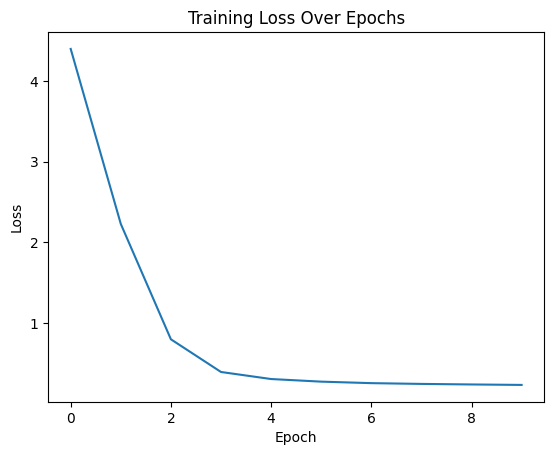

In [19]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

In [21]:
!ls -al

total 6351396
drwxr-xr-x 1 root root      4096 Feb 24 12:13 .
drwxr-xr-x 1 root root      4096 Feb 24 11:50 ..
drwxr-xr-x 4 root root      4096 Feb 20 14:24 .config
drwxr-xr-x 2 root root      4096 Feb 24 12:00 harry_data
-rw-r--r-- 1 root root   2390829 May  3  2024 harry-potter-books.zip
-rw-r--r-- 1 root root 650136058 Feb 24 12:04 model_001.pth
-rw-r--r-- 1 root root 650136058 Feb 24 12:05 model_002.pth
-rw-r--r-- 1 root root 650136058 Feb 24 12:06 model_003.pth
-rw-r--r-- 1 root root 650136058 Feb 24 12:07 model_004.pth
-rw-r--r-- 1 root root 650136058 Feb 24 12:08 model_005.pth
-rw-r--r-- 1 root root 650136058 Feb 24 12:09 model_006.pth
-rw-r--r-- 1 root root 650136058 Feb 24 12:10 model_007.pth
-rw-r--r-- 1 root root 650136058 Feb 24 12:11 model_008.pth
-rw-r--r-- 1 root root 650136058 Feb 24 12:12 model_009.pth
-rw-r--r-- 1 root root 650136058 Feb 24 12:13 model_010.pth
drwxr-xr-x 1 root root      4096 Feb 20 14:24 sample_data


#### 결과 확인

In [22]:
# 파일로 저장했던 네트워크의 가중치들 읽어들이기
model.load_state_dict(torch.load("model_010.pth", map_location=device, weights_only=True))
model.eval() # dropout을 사용하지 않음

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(128, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [23]:
idx = tokenizer.encode("Dobby is") # 토큰 id의 list
idx = torch.tensor(idx).unsqueeze(0).to(device)

with torch.no_grad():
    logits = model(idx)

logits = logits[:, -1, :]

# 가장 확률이 높은 단어 10개 출력
top_logits, top_indices = torch.topk(logits, 10)
for p, i in zip(top_logits.squeeze(0).tolist(), top_indices.squeeze(0).tolist()):
    print(f"{p:.2f}\t {i}\t {tokenizer.decode([i])}")

# 가장 확률이 높은 단어 출력
idx_next = torch.argmax(logits, dim=-1, keepdim=True)
flat = idx_next.squeeze(0) # 배치 차원 제거 torch.Size([1])
out = tokenizer.decode(flat.tolist()) # 텐서를 리스트로 바꿔서 디코드
print(out)

12.18	 257	  a
10.22	 991	  still
10.00	 1479	  free
9.51	 973	  used
8.74	 11	 ,
8.58	 1908	  sent
8.48	 3338	  safe
8.45	 1464	  always
8.24	 4762	  believed
7.96	 8161	  careful
 a


In [24]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [26]:
start_context = input("Start context: ")

# idx = tokenizer.encode(start_context, allowed_special={'<|endoftext|>'})
idx = tokenizer.encode(start_context)
idx = torch.tensor(idx).unsqueeze(0)

context_size = model.pos_emb.weight.shape[0]

for i in range(10):

    token_ids = generate(
        model=model,
        idx=idx.to(device),
        max_new_tokens=50,
        context_size= context_size,
        top_k=50,
        temperature=0.5
    )

    flat = token_ids.squeeze(0) # remove batch dimension
    out = tokenizer.decode(flat.tolist()).replace("\n", " ")

    print(i, ":", out)

Start context: what is your
0 : what is your best friends only, of course.” “I wouldn’t bet on that,” Harry murmured, watching Snape baring his teeth into the passage his teeth excitedly at the elf came to say anything — “…
1 : what is your trunk we know who thinks Muggle-borns are scum?” He looked at Hermione. Hermione looked back, unconvinced. “If Lockhart’s where you’s hand on top of a trolley around
2 : what is your trunk right away,” snapped Professor Binns. “I repeat, if the likes of Dumbledore —” “But maybe you” said if he will be dangerous, Professor McGonagall thinks he certainly kept watch you haven
3 : what is your —” Hagrid leapt to his feet, his shaggy black head grazing the ceiling. ‘An’ how many did yeh have been she could possibly suspect him when You-borns had said he could go,’
4 : what is your singing sorcerers —” He stuttered to a halt. Hermione’s hand was waving in the air again. “Miss Grant?’s a Draco how many students could goggily quiet.” “You could
5 : what is 